In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/car-price-prediction/CarPrice_Assignment.csv
/kaggle/input/car-price-prediction/Data Dictionary - carprices.xlsx


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.metrics import r2_score,mean_absolute_error
from sklearn.model_selection import cross_val_score,GridSearchCV,train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor

UNDERSTANDING THE DATA

In [3]:
df = pd.read_csv("/kaggle/input/car-price-prediction/CarPrice_Assignment.csv")
pd.set_option('display.max_columns', None)
print(df.shape)
df.head()

(205, 26)


,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [4]:
df.isnull().sum().sum()

0

In [5]:
df.drop(["car_ID"],axis = 1,inplace = True)


<AxesSubplot:xlabel='wheelbase'>

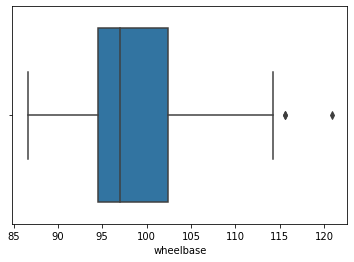

In [6]:
import seaborn as sns
sns.boxplot(x = df["wheelbase"])

In [7]:
df.info()



#carSizes = []
#for i in df.index:
#    newSize= df.carlength * df.carheight * df.carwidth
#    carSizes.append(newSize)
#    
#df.insert(2,"carSize",carSizes[i],True)
#df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symboling         205 non-null    int64  
 1   CarName           205 non-null    object 
 2   fueltype          205 non-null    object 
 3   aspiration        205 non-null    object 
 4   doornumber        205 non-null    object 
 5   carbody           205 non-null    object 
 6   drivewheel        205 non-null    object 
 7   enginelocation    205 non-null    object 
 8   wheelbase         205 non-null    float64
 9   carlength         205 non-null    float64
 10  carwidth          205 non-null    float64
 11  carheight         205 non-null    float64
 12  curbweight        205 non-null    int64  
 13  enginetype        205 non-null    object 
 14  cylindernumber    205 non-null    object 
 15  enginesize        205 non-null    int64  
 16  fuelsystem        205 non-null    object 
 1

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
symboling,205.0,0.834146,1.245307,-2.00,0.00,1.00,2.00,3.00
wheelbase,205.0,98.756585,6.021776,86.60,94.50,97.00,102.40,120.90
carlength,205.0,174.049268,12.337289,141.10,166.30,173.20,183.10,208.10
carwidth,205.0,65.907805,2.145204,60.30,64.10,65.50,66.90,72.30
carheight,205.0,53.724878,2.443522,47.80,52.00,54.10,55.50,59.80
curbweight,205.0,2555.565854,520.680204,1488.00,2145.00,2414.00,2935.00,4066.00
enginesize,205.0,126.907317,41.642693,61.00,97.00,120.00,141.00,326.00
boreratio,205.0,3.329756,0.270844,2.54,3.15,3.31,3.58,3.94
stroke,205.0,3.255415,0.313597,2.07,3.11,3.29,3.41,4.17
compressionratio,205.0,10.142537,3.972040,7.00,8.60,9.00,9.40,23.00


PRICE EFFECTS OF SOME FEATURES

In [9]:
def priceEffect(var):
    print("          ")
    print("{var}".format(var = var))
    print("          ")
    sns.barplot(x = df["{var}".format(var=var)],y =df["price"],palette ='plasma')

          
symboling
          


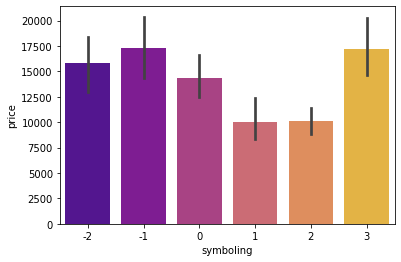

In [10]:
priceEffect("symboling")

          
aspiration
          


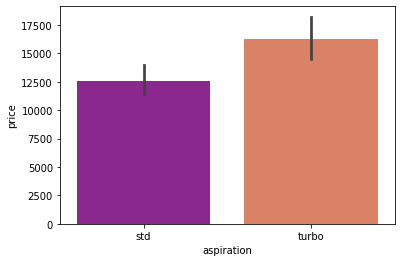

In [11]:
priceEffect("aspiration")

          
doornumber
          


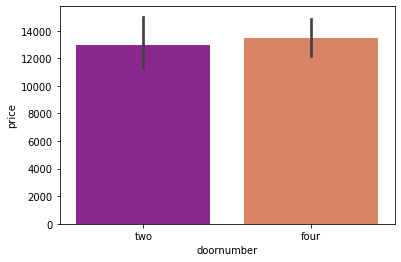

In [12]:
priceEffect("doornumber")

          
aspiration
          


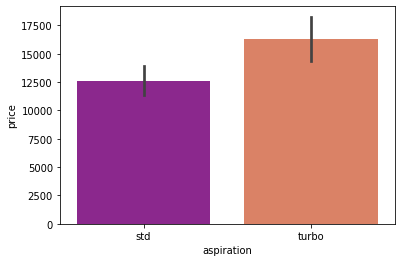

In [13]:
priceEffect("aspiration")

          
carbody
          


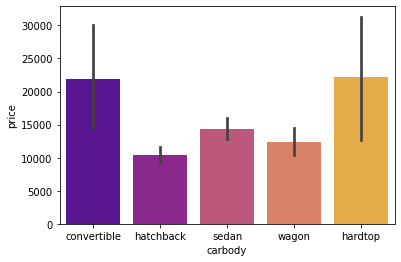

In [14]:
priceEffect("carbody")

          
drivewheel
          


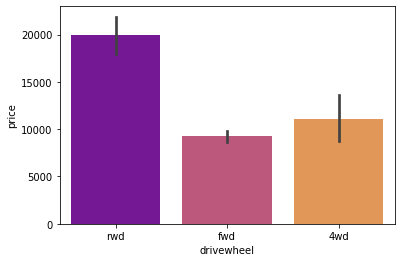

In [15]:
priceEffect("drivewheel")

          
enginelocation
          


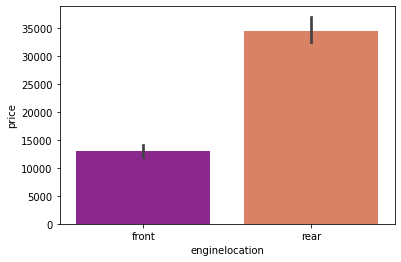

In [16]:
priceEffect("enginelocation")

          
carwidth
          


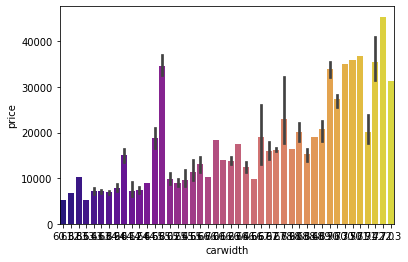

In [17]:
priceEffect("carwidth")

          
curbweight
          


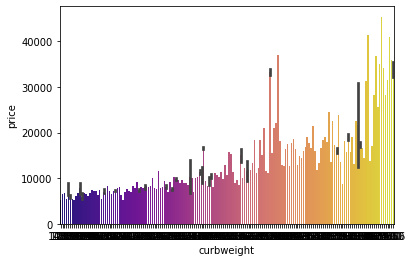

In [18]:
priceEffect("curbweight")


# EASILY UNDERSTAND THAT IF CAR MORE WIDE AND BIG ITS MORE EXPENSIVE

          
enginetype
          


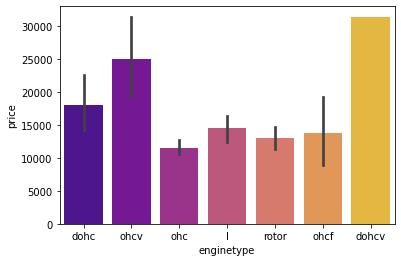

In [19]:
priceEffect("enginetype")

          
enginesize
          


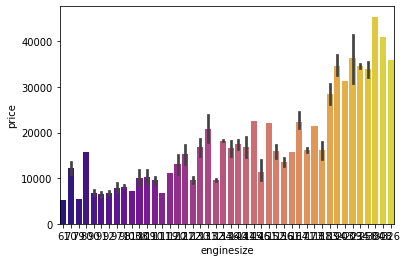

In [20]:
priceEffect("enginesize")

          
fuelsystem
          


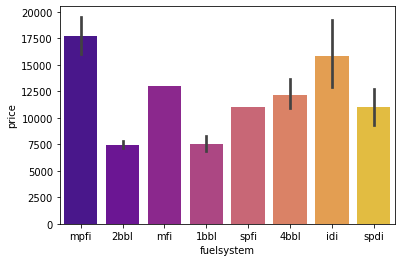

In [21]:
priceEffect("fuelsystem")

          
boreratio
          


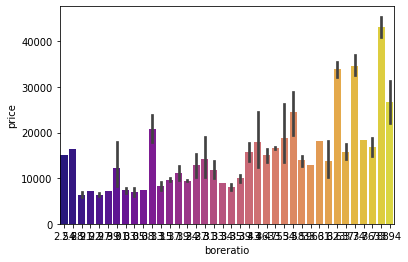

In [22]:
priceEffect("boreratio")

          
stroke
          


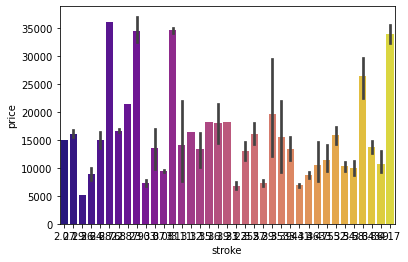

In [23]:
priceEffect("stroke")

          
compressionratio
          


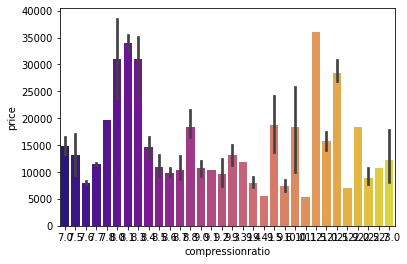

In [24]:
priceEffect("compressionratio")

          
horsepower
          


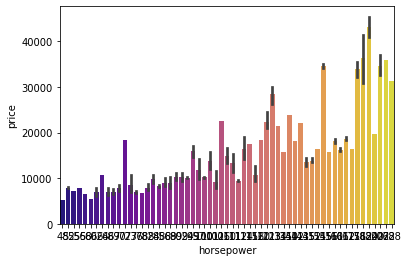

In [25]:
priceEffect("horsepower")

          
peakrpm
          


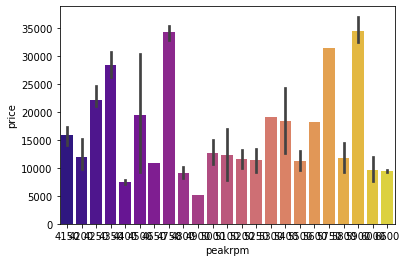

In [26]:
priceEffect("peakrpm")

          
citympg
          


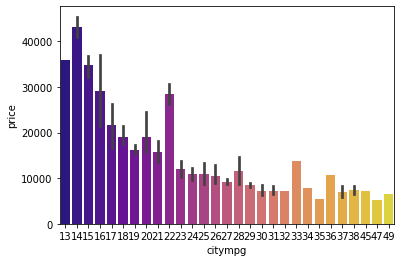

In [27]:
priceEffect("citympg")

          
highwaympg
          


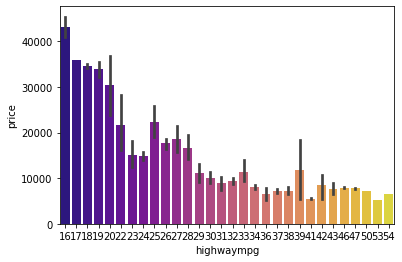

In [28]:
priceEffect("highwaympg")

DATA PREPROCESSING

In [29]:
df.isnull().sum().sum()

0

In [30]:
for i in df.columns:
    if (df[i].dtype == "int64") or (df[i].dtype == "float64"):
        print(i)

symboling
wheelbase
carlength
carwidth
carheight
curbweight
enginesize
boreratio
stroke
compressionratio
horsepower
peakrpm
citympg
highwaympg
price


<AxesSubplot:xlabel='symboling'>

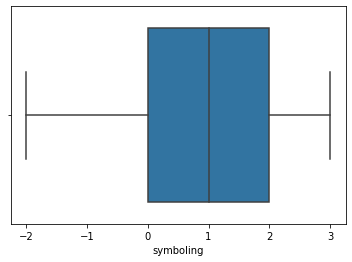

In [31]:
sns.boxplot(x = df["symboling"])

<AxesSubplot:xlabel='wheelbase'>

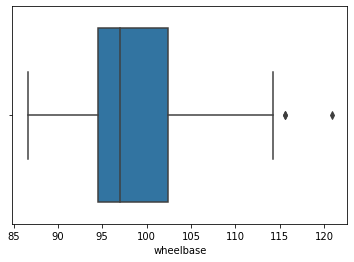

In [32]:
sns.boxplot(x = df["wheelbase"])

<AxesSubplot:xlabel='carlength'>

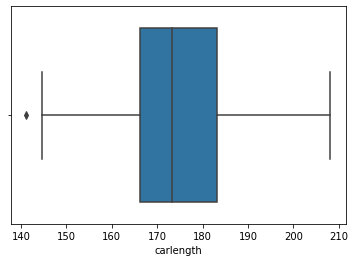

In [33]:
sns.boxplot(x = df["carlength"])

<AxesSubplot:xlabel='carwidth'>

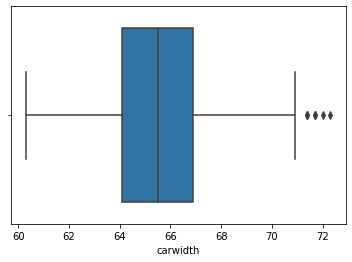

In [34]:
sns.boxplot(x = df["carwidth"])

<AxesSubplot:xlabel='carheight'>

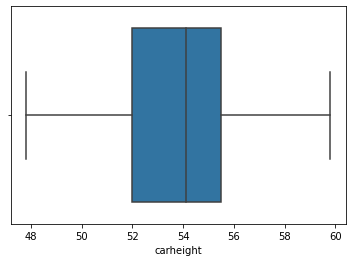

In [35]:
sns.boxplot(x = df["carheight"])

<AxesSubplot:xlabel='curbweight'>

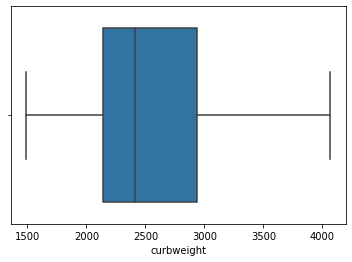

In [36]:
sns.boxplot(x = df["curbweight"])

<AxesSubplot:xlabel='enginesize'>

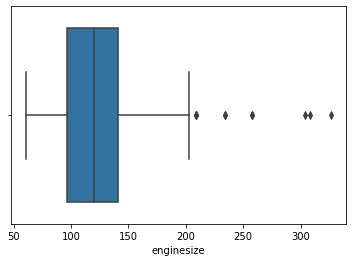

In [37]:
sns.boxplot(x = df["enginesize"])

<AxesSubplot:xlabel='boreratio'>

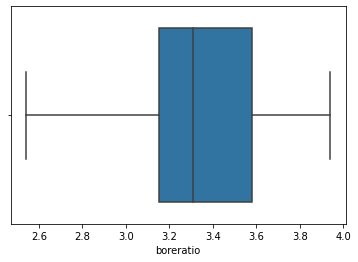

In [38]:
sns.boxplot(x = df["boreratio"])

<AxesSubplot:xlabel='stroke'>

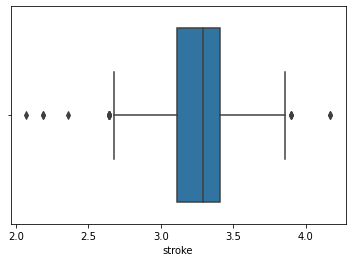

In [39]:
sns.boxplot(x = df["stroke"])

<AxesSubplot:xlabel='compressionratio'>

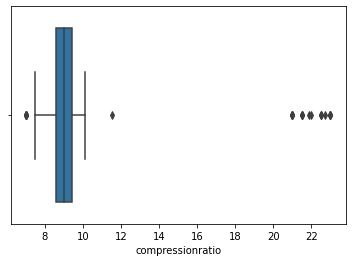

In [40]:
sns.boxplot(x = df["compressionratio"])

# ITS REALLY INTERESTING THAT HAVE ANORMAL COMPRESSION RATIOS

In [41]:
print(df.compressionratio.mean())
for i in df.compressionratio:
    if i> 11:
        print(i)
df.loc[df['compressionratio'] > 11]

10.142536585365855
11.5
22.7
22.0
21.5
21.5
21.5
21.5
21.9
21.0
21.0
21.0
21.0
21.0
22.5
22.5
22.5
23.0
23.0
23.0
23.0
23.0


,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
49,0,jaguar xk,gas,std,two,sedan,rwd,front,102.0,191.7,70.6,47.8,3950,ohcv,twelve,326,mpfi,3.54,2.76,11.5,262,5000,13,17,36000.0
63,0,mazda glc deluxe,diesel,std,four,sedan,fwd,front,98.8,177.8,66.5,55.5,2443,ohc,four,122,idi,3.39,3.39,22.7,64,4650,36,42,10795.0
66,0,mazda rx-7 gs,diesel,std,four,sedan,rwd,front,104.9,175.0,66.1,54.4,2700,ohc,four,134,idi,3.43,3.64,22.0,72,4200,31,39,18344.0
67,-1,buick electra 225 custom,diesel,turbo,four,sedan,rwd,front,110.0,190.9,70.3,56.5,3515,ohc,five,183,idi,3.58,3.64,21.5,123,4350,22,25,25552.0
68,-1,buick century luxus (sw),diesel,turbo,four,wagon,rwd,front,110.0,190.9,70.3,58.7,3750,ohc,five,183,idi,3.58,3.64,21.5,123,4350,22,25,28248.0
69,0,buick century,diesel,turbo,two,hardtop,rwd,front,106.7,187.5,70.3,54.9,3495,ohc,five,183,idi,3.58,3.64,21.5,123,4350,22,25,28176.0
70,-1,buick skyhawk,diesel,turbo,four,sedan,rwd,front,115.6,202.6,71.7,56.3,3770,ohc,five,183,idi,3.58,3.64,21.5,123,4350,22,25,31600.0
90,1,nissan gt-r,diesel,std,two,sedan,fwd,front,94.5,165.3,63.8,54.5,2017,ohc,four,103,idi,2.99,3.47,21.9,55,4800,45,50,7099.0
108,0,peugeot 304,diesel,turbo,four,sedan,rwd,front,107.9,186.7,68.4,56.7,3197,l,four,152,idi,3.70,3.52,21.0,95,4150,28,33,13200.0
110,0,peugeot 504,diesel,turbo,four,wagon,rwd,front,114.2,198.9,68.4,58.7,3430,l,four,152,idi,3.70,3.52,21.0,95,4150,25,25,13860.0


<AxesSubplot:xlabel='horsepower'>

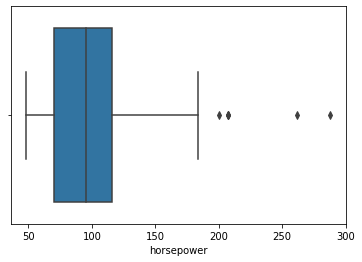

In [42]:
sns.boxplot(x = df["horsepower"])

<AxesSubplot:xlabel='peakrpm'>

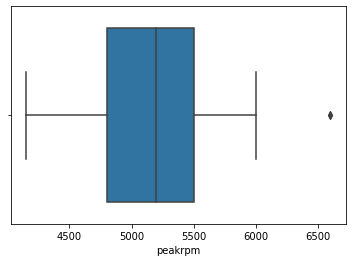

In [43]:
sns.boxplot(x = df["peakrpm"])

<AxesSubplot:xlabel='citympg'>

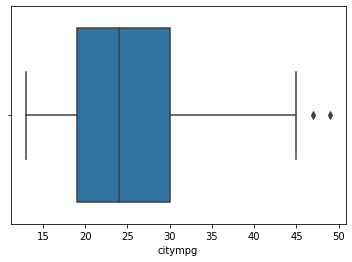

In [44]:
sns.boxplot(x = df["citympg"])

<AxesSubplot:xlabel='highwaympg'>

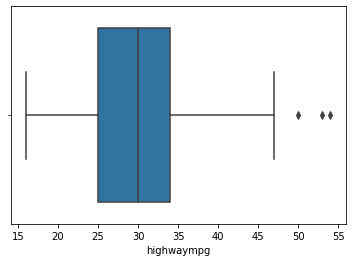

In [45]:
sns.boxplot(x = df["highwaympg"])

In [46]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3-Q1
print(IQR)

symboling              2.00
wheelbase              7.90
carlength             16.80
carwidth               2.80
carheight              3.50
curbweight           790.00
enginesize            44.00
boreratio              0.43
stroke                 0.30
compressionratio       0.80
horsepower            46.00
peakrpm              700.00
citympg               11.00
highwaympg             9.00
price               8715.00
dtype: float64


In [47]:
BBound = Q1-1.5*IQR
TBound = Q3 + 1.5*IQR
for i in IQR.index:
    print(i,"---",
          round(BBound[i]),"---",round(TBound[i]))

symboling --- -3 --- 5
wheelbase --- 83 --- 114
carlength --- 141 --- 208
carwidth --- 60 --- 71
carheight --- 47 --- 61
curbweight --- 960 --- 4120
enginesize --- 31 --- 207
boreratio --- 3 --- 4
stroke --- 3 --- 4
compressionratio --- 7 --- 11
horsepower --- 1 --- 185
peakrpm --- 3750 --- 6550
citympg --- 2 --- 46
highwaympg --- 12 --- 48
price --- -5284 --- 29576


In [48]:
for i in TBound.index:
    TOut = df[i] > TBound[i]
    BOut = df[i] < BBound[i]
    
    
    df[i][TOut] = TBound[i]
    df[i][BOut] = BBound[i]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning

In [49]:
df.corr()["price"].sort_values(ascending = False)

price               1.000000
curbweight          0.864597
enginesize          0.860063
horsepower          0.821715
carwidth            0.783230
carlength           0.712455
wheelbase           0.595909
boreratio           0.572685
carheight           0.142033
stroke              0.073830
compressionratio   -0.056573
peakrpm            -0.088630
symboling          -0.092705
citympg            -0.718290
highwaympg         -0.733692
Name: price, dtype: float64

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symboling         205 non-null    int64  
 1   CarName           205 non-null    object 
 2   fueltype          205 non-null    object 
 3   aspiration        205 non-null    object 
 4   doornumber        205 non-null    object 
 5   carbody           205 non-null    object 
 6   drivewheel        205 non-null    object 
 7   enginelocation    205 non-null    object 
 8   wheelbase         205 non-null    float64
 9   carlength         205 non-null    float64
 10  carwidth          205 non-null    float64
 11  carheight         205 non-null    float64
 12  curbweight        205 non-null    int64  
 13  enginetype        205 non-null    object 
 14  cylindernumber    205 non-null    object 
 15  enginesize        205 non-null    int64  
 16  fuelsystem        205 non-null    object 
 1

In [51]:
df.head()

,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21.0,27.0,13495.0
1,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21.0,27.0,16500.0
2,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19.0,26.0,16500.0
3,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24.0,30.0,13950.0
4,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18.0,22.0,17450.0


In [52]:
for i in range(len(df.iloc[:,0])):
    list = df["CarName"][i].split(" ",1)
    df["CarName"][i] = list[0]
    list = []
df["CarName"]
    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0      alfa-romero
1      alfa-romero
2      alfa-romero
3             audi
4             audi
          ...     
200          volvo
201          volvo
202          volvo
203          volvo
204          volvo
Name: CarName, Length: 205, dtype: object

In [53]:
df.head()

,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,3,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21.0,27.0,13495.0
1,3,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21.0,27.0,16500.0
2,1,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19.0,26.0,16500.0
3,2,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24.0,30.0,13950.0
4,2,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18.0,22.0,17450.0


In [54]:
LabEnc = {}

df_cat = df.select_dtypes(include = [np.object])
for i in df_cat:
    LabEnc[i] = OneHotEncoder()
    df[i] = LabEnc[i].fit_transform(df[i].values.reshape(-1, 1)).toarray()
    
df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,3,0.0,0.0,1.0,0.0,1.0,0.0,1.0,88.6,168.8,64.1,48.8,2548,1.0,0.0,130,0.0,3.47,2.68,9.0,111,5000,21.0,27.0,13495.0
1,3,0.0,0.0,1.0,0.0,1.0,0.0,1.0,88.6,168.8,64.1,48.8,2548,1.0,0.0,130,0.0,3.47,2.68,9.0,111,5000,21.0,27.0,16500.0
2,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,94.5,171.2,65.5,52.4,2823,0.0,0.0,152,0.0,2.68,3.47,9.0,154,5000,19.0,26.0,16500.0
3,2,0.0,0.0,1.0,1.0,0.0,0.0,1.0,99.8,176.6,66.2,54.3,2337,0.0,0.0,109,0.0,3.19,3.40,10.0,102,5500,24.0,30.0,13950.0
4,2,0.0,0.0,1.0,1.0,0.0,1.0,1.0,99.4,176.6,66.4,54.3,2824,0.0,0.0,136,0.0,3.19,3.40,8.0,115,5500,18.0,22.0,17450.0


In [55]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symboling         205 non-null    int64  
 1   CarName           205 non-null    float64
 2   fueltype          205 non-null    float64
 3   aspiration        205 non-null    float64
 4   doornumber        205 non-null    float64
 5   carbody           205 non-null    float64
 6   drivewheel        205 non-null    float64
 7   enginelocation    205 non-null    float64
 8   wheelbase         205 non-null    float64
 9   carlength         205 non-null    float64
 10  carwidth          205 non-null    float64
 11  carheight         205 non-null    float64
 12  curbweight        205 non-null    int64  
 13  enginetype        205 non-null    float64
 14  cylindernumber    205 non-null    float64
 15  enginesize        205 non-null    int64  
 16  fuelsystem        205 non-null    float64
 1

MODELING

In [56]:
x = df.drop(["price"],axis = 1)           
y = df["price"]    

# split the data train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

NameError: name 'train_test_split' is not defined

In [ ]:
print("X Train : ", x_train.shape)
print("X Test  : ", x_test.shape)
print("Y Train : ", y_train.shape)
print("Y Test  : ", y_test.shape)

In [ ]:
LR = LinearRegression()
XGBR = XGBRegressor()
SVR = SVR()


In [ ]:
models = [LR,XGBR,SVR]
for i in models:
    print(i)
    i.fit(x_train,y_train)
    
    print("test")
    print(i,"score is :",r2_score(y_test,i.predict(x_test)),mean_absolute_error(y_test,i.predict(x_test)))
    
    print("train")
    print(i,"score is :",r2_score(y_train,i.predict(x_train)),mean_absolute_error(y_train,i.predict(x_train)))
    print("   ")
    print("   ")
    print("   ")

In [ ]:
Table = pd.DataFrame({"y":round(y_test[0:20]),"prediction":XGBR.predict(x_test)[0:20].round(),"difference":round(y_test[0:20]- XGBR.predict(x_test)[0:20])})
Table

In [ ]:
#XGB = 0.9663621354321177  on TEST 
#XGB = 0.9985726419765655   on TRAIN
